In [1]:
%load_ext tensorboard
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime


#name of model or experiment
model_name = "CNOT_Model"
log_dir= model_name + "/runs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='batch',
    profile_batch=1,
    embeddings_freq=1,
    embeddings_metadata=None
)

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_batches = 128     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()


tf.config.get_visible_devices()


n_qubits = 4

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

dev = qml.device("default.qubit.tf", wires=n_qubits)


2024-08-11 10:30:05.703514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 10:30:06.425509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-11 10:30:07.123948: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-08-11 10:30:07.123987: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-08-11 10:30:07.130106: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-08-11 10:30:07.418441: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-11 10:30:07.4184

In [2]:
keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class BasicLayer(keras.layers.Layer):
    

    def call(self, inputs):
        """Preprocessing without quantum network.
        splits input in to four channels

        Args:
            inputs ([type]): [description]

        Returns:
            [type]: [description]
        """        

        rotate_14x14 = lambda subsection_14x14: tf.vectorized_map(lambda chanel: tf.transpose(chanel),subsection_14x14)

        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])

        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(tf.transpose(rotate_14x14(tf.transpose(get_subsections_14x14(image))))),
            input
        )

        return preprocessing(inputs)
qlayer = BasicLayer()

qlayer.trainable = False

In [3]:
#wrap preprocessing in model

@keras.utils.register_keras_serializable(package=(model_name+"_Pre_Model"))
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        qlayer
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

In [4]:
#core model

@keras.utils.register_keras_serializable(package=(model_name+"_Core_Model"))
def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Rescaling(scale=1./127.5, offset=-1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

q_model = Q_Model()

#preprocessing
pre_train_images = pre_model.predict(train_images,batch_size=n_batches)
pre_test_images = pre_model.predict(test_images,batch_size=n_batches)


 25/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [5]:

#training
q_history = q_model.fit(
    pre_train_images[:,:,:,[1,2]],
    train_labels,
    validation_data=(pre_test_images[:,:,:,[1,2]], test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2, callbacks=[tensorboard_callback]
)


Epoch 1/30


2024-08-11 10:30:10.630471: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-08-11 10:30:10.630517: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-08-11 10:30:11.020807: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-08-11 10:30:11.022733: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-08-11 10:30:11.023044: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: CNOT_Model/runs/20240811-103007/plugins/profile/2024_08_11_10_30_11/1ba22281c77a.xplane.pb


469/469 - 2s - 5ms/step - accuracy: 0.7634 - loss: 0.6989 - val_accuracy: 0.8064 - val_loss: 0.5596
Epoch 2/30
469/469 - 2s - 4ms/step - accuracy: 0.8240 - loss: 0.5049 - val_accuracy: 0.8203 - val_loss: 0.5141
Epoch 3/30
469/469 - 2s - 4ms/step - accuracy: 0.8361 - loss: 0.4714 - val_accuracy: 0.8277 - val_loss: 0.4948
Epoch 4/30
469/469 - 2s - 3ms/step - accuracy: 0.8423 - loss: 0.4543 - val_accuracy: 0.8313 - val_loss: 0.4840
Epoch 5/30
469/469 - 2s - 4ms/step - accuracy: 0.8462 - loss: 0.4436 - val_accuracy: 0.8337 - val_loss: 0.4770
Epoch 6/30
469/469 - 2s - 4ms/step - accuracy: 0.8487 - loss: 0.4361 - val_accuracy: 0.8359 - val_loss: 0.4722
Epoch 7/30
469/469 - 2s - 4ms/step - accuracy: 0.8504 - loss: 0.4304 - val_accuracy: 0.8370 - val_loss: 0.4688
Epoch 8/30
469/469 - 2s - 4ms/step - accuracy: 0.8522 - loss: 0.4260 - val_accuracy: 0.8389 - val_loss: 0.4661
Epoch 9/30
469/469 - 2s - 4ms/step - accuracy: 0.8533 - loss: 0.4225 - val_accuracy: 0.8385 - val_loss: 0.4641
Epoch 10/30


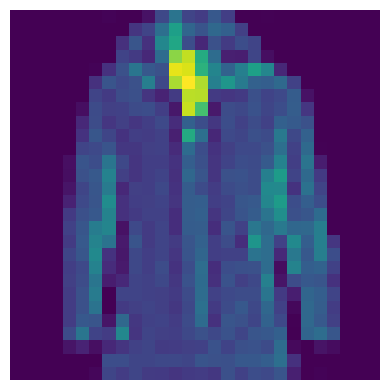

In [6]:

sample = np.asarray(train_images[19,:,:]).copy()

#sample[:,:,[1,2]] = np.NAN

compdiffs = (sample)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

ax.imshow(compdiffs)
ax.axis('off')


plt.tight_layout()
plt.show()

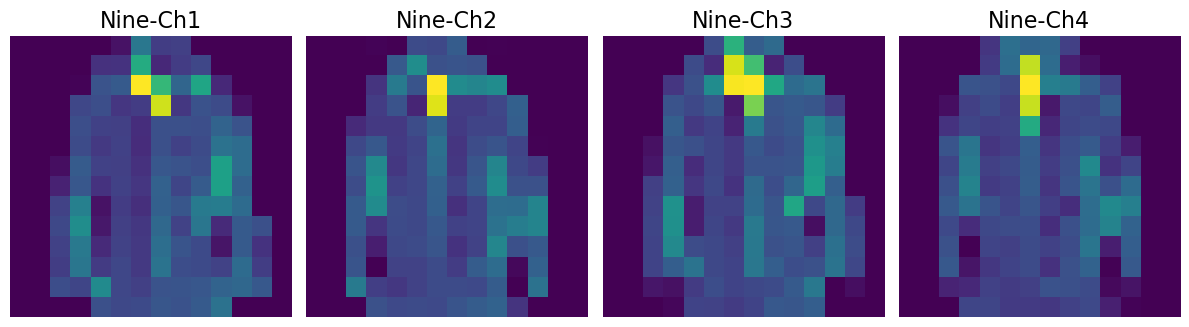

In [7]:
#example of quantum preprocessed(filtered) chanels
image_titles = ['Nine-Ch1', 'Nine-Ch2', 'Nine-Ch3','Nine-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(pre_train_images[19][:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()


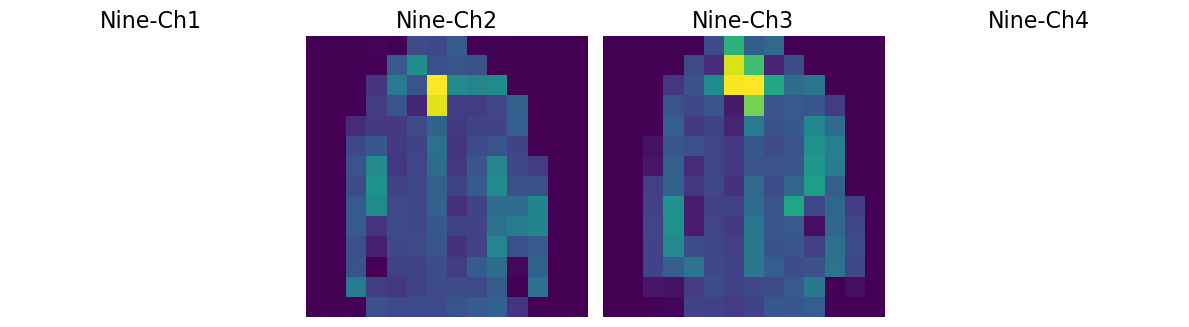

In [8]:
sample = np.asarray(pre_train_images[19]).copy()

sample[:,:,[0,3]] = np.NAN

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(sample[:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

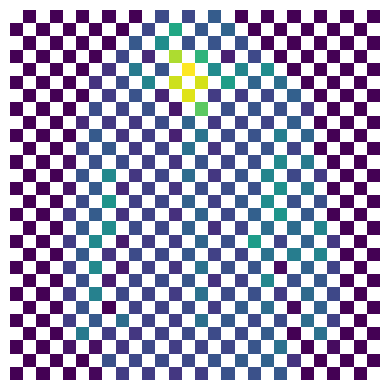

In [9]:


reassembled_pt1 = lambda square: tf.reshape(tf.vectorized_map(lambda inp: tf.transpose(inp),tf.transpose(square)),[2,14,2,14])

reassembled = lambda square: tf.reshape(tf.stack(tf.reshape(tf.stack(reassembled_pt1(square),axis=2),[2,28*14]),axis=1),[28,28])

compdiffs = reassembled(sample[:,:,[0,1,2,3]])

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow(compdiffs)
ax.axis('off')


plt.tight_layout()
plt.show()

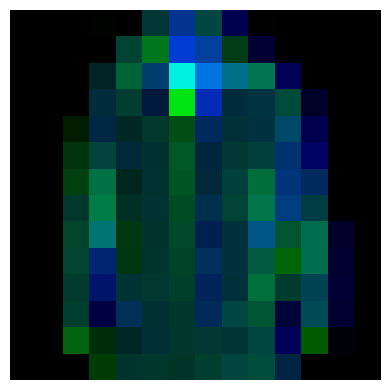

In [15]:

sample[:,:,[0]]=0
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow((sample[:,:,[0,1,2]])/(255))
ax.axis('off')


plt.tight_layout()
plt.show()

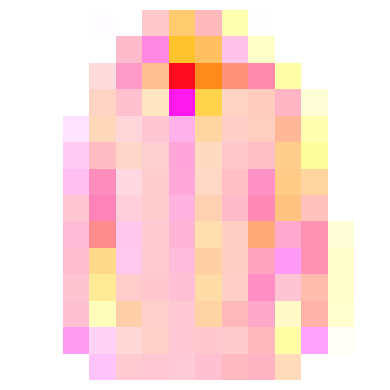

In [13]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.imshow((sample[:,:,[0,1,2]]/(-255))+1)
ax.axis('off')


plt.tight_layout()
plt.show()